# Autism Detection in Early Childhood
## UNC-Charlotte MIL Final Project
### Authors: Mark McAfoose, Mesut Koroglu, Mubeen Quadrt
mmcafoos@uncc.edu | mkoroglu@uncc.edu | mquadrt@uncc.edu

#### Importing the Libraries used

In [49]:
# Goal - Looking to build Autism Spectrum Disorder model for detection while not affecting accuracy

# libraries used:

import warnings

import matplotlib.pyplot as plt
from numpy import mean
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [50]:
autism = pd.read_csv("taDataset.csv")   # Dataset import
autism.sample(5)                        # 5 indeces

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
556,557,1,1,0,1,0,0,1,0,1,1,22,6,m,White European,no,yes,family member,Yes
859,860,1,1,1,1,1,1,1,1,1,1,19,10,m,White European,yes,no,family member,Yes
964,965,1,0,1,1,1,1,1,0,1,0,16,7,m,White European,no,yes,family member,Yes
309,310,1,1,1,0,1,0,0,0,1,0,36,5,m,south asian,yes,yes,Health Care Professional,Yes
174,175,0,1,0,0,0,0,0,0,0,1,36,2,f,White European,yes,yes,family member,No


#### Displaying the available Data as is

In [51]:
print("Data Shape: ", autism.shape)      # Dimension

Data Shape:  (1054, 19)


In [52]:
# There are 1054 entrys of toddlers and 19 respective columns addressing the Q10 questions and characterstics of toddlers

print("Data info: ", autism.info())
print("\n" * 3)
print("Data description: ", autism.describe())
print("\n" * 3)
print("Dataset has: ", autism.isnull().sum().sum(), " missing values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Case_No                 1054 non-null   int64 
 1   A1                      1054 non-null   int64 
 2   A2                      1054 non-null   int64 
 3   A3                      1054 non-null   int64 
 4   A4                      1054 non-null   int64 
 5   A5                      1054 non-null   int64 
 6   A6                      1054 non-null   int64 
 7   A7                      1054 non-null   int64 
 8   A8                      1054 non-null   int64 
 9   A9                      1054 non-null   int64 
 10  A10                     1054 non-null   int64 
 11  Age_Mons                1054 non-null   int64 
 12  Qchat-10-Score          1054 non-null   int64 
 13  Sex                     1054 non-null   object
 14  Ethnicity               1054 non-null   object
 15  Jaun

In [53]:
print(
    "Diagonised with ASD = ",                                  # Fetching # of diagnosed instances
    len(autism[autism["Class/ASD Traits "] == "Yes"]),
    "\n",
    "Undiagonised with ASD = ",                                # Fetching # of undiagnosed instances
    len(autism[autism["Class/ASD Traits "] == "No"]),
)

Diagonised with ASD =  728 
 Undiagonised with ASD =  326


#### Plotting the initial graphs corelating with features

Text(0.5, 1.0, 'Data Count')

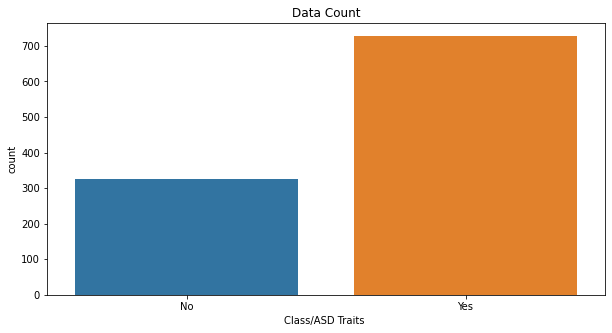

In [54]:
warnings.filterwarnings("ignore")

# Graph Recap of data:

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(autism["Class/ASD Traits "])
plt.title("Data Count")

Text(0.5, 1.0, "Toddler's dataset")

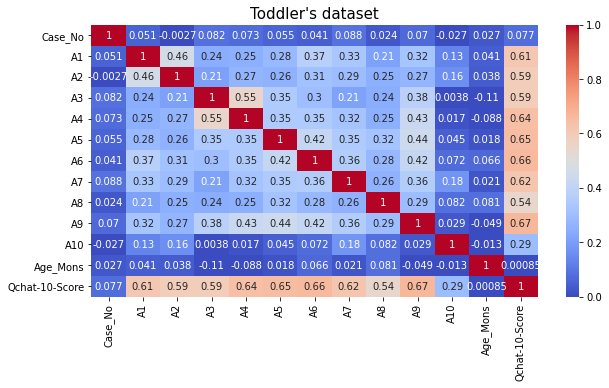

In [55]:
# Heat map for Responses Q10:

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(autism.corr(), annot=True, cmap="coolwarm", vmin=0, vmax=1)

plt.title("Toddler's dataset", fontsize=15)

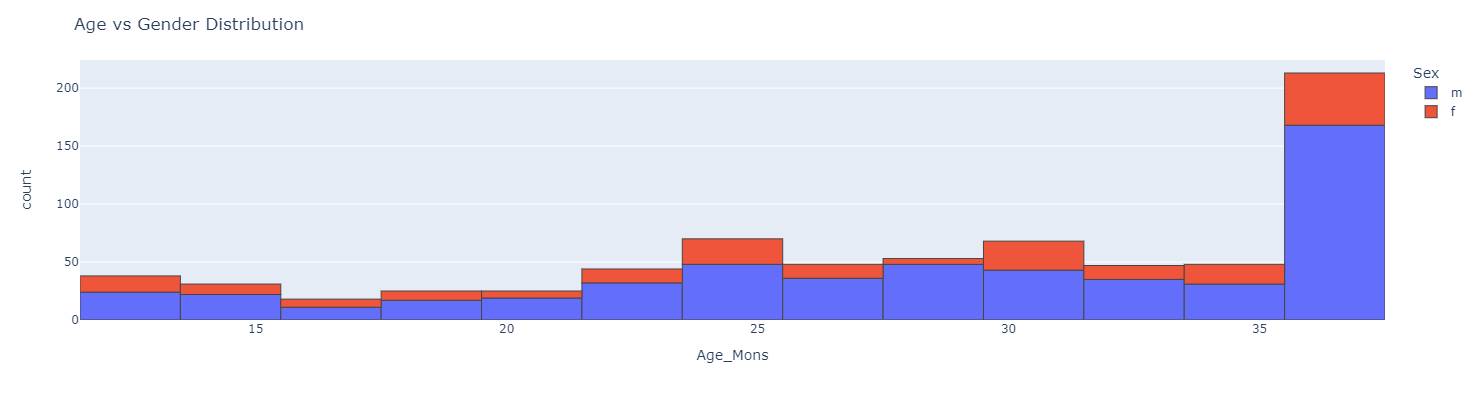

In [56]:
import plotly.express as px
import pandas as pd

# histogram and layout:

autism = pd.read_csv('taDataset.csv')
fig = px.histogram(autism[autism['Class/ASD Traits '] == 'Yes'],
                   x="Age_Mons",
                   color="Sex")
fig.update_layout(autosize=False,
                  width=600,
                  height=400,
                  title="Age vs Gender Distribution")
fig.update_traces(marker_line_width=1)
fig.show()

## Data Adjustment

In [57]:
# Q 10 Scoring  and Characterstics:

autism.rename(
    columns={
        "Case_No": "id",
        "A1": "A1_Score",
        "A2": "A2_Score",
        "A3": "A3_Score",
        "A4": "A4_Score",
        "A5": "A5_Score",
        "A6": "A6_Score",
        "A7": "A7_Score",
        "A8": "A8_Score",
        "A9": "A9_Score",
        "A10": "A10_Score",
        "Sex": "gender",
        "Ethnicity": "ethnicity",
        "Jaundice": "jundice",
        "Family_mem_with_ASD": "austim",
        "Who completed the test": "relation",
        "Class/ASD Traits ": "Class/ASD",
        "Qchat-10-Score": "result",
    },
    inplace=True,
)

raw_target = autism["Class/ASD"]
raw_features = autism[
    [
        "A1_Score",
        "A2_Score",
        "A3_Score",
        "A4_Score",
        "A5_Score",
        "A6_Score",
        "A7_Score",
        "A8_Score",
        "A9_Score",
        "A10_Score",
        "Age_Mons",
        "gender",
        "ethnicity",
        "jundice",
        "austim",
        "result",
        "relation",
    ]
]
scaler = MinMaxScaler()
num_features = ["Age_Mons", "result"]

features_minmax_transform = pd.DataFrame(data=raw_features)
features_minmax_transform[num_features] = scaler.fit_transform(
    raw_features[num_features]
)

In [58]:
features_minmax_transform.head(10)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,Age_Mons,gender,ethnicity,jundice,austim,result,relation
0,0,0,0,0,0,0,1,1,0,1,0.666667,f,middle eastern,yes,no,0.3,family member
1,1,1,0,0,0,1,1,0,0,0,1.000000,m,White European,yes,no,0.4,family member
2,1,0,0,0,0,0,1,1,0,1,1.000000,m,middle eastern,yes,no,0.4,family member
3,1,1,1,1,1,1,1,1,1,1,0.500000,m,Hispanic,no,no,1.0,family member
4,1,1,0,1,1,1,1,1,1,1,0.333333,f,White European,no,yes,0.9,family member
5,1,1,0,0,1,1,1,1,1,1,0.375000,m,black,no,no,0.8,family member
6,1,0,0,1,1,1,0,0,1,0,0.875000,m,asian,yes,no,0.5,family member
7,0,1,0,0,1,0,1,1,1,1,0.875000,m,asian,yes,no,0.6,family member
8,0,0,0,0,0,0,1,0,0,1,1.000000,m,asian,no,no,0.2,family member
9,1,1,1,0,1,1,0,1,1,1,0.416667,m,south asian,no,no,0.8,Health Care Professional


In [59]:
features = pd.get_dummies(features_minmax_transform)

le = LabelEncoder()
target = le.fit_transform(raw_target)

# model report - precision, recall, accuracy

def model_report(y_act, y_pred):
    from sklearn.metrics import (
        accuracy_score,
        f1_score,
        precision_score,
        recall_score,
        cohen_kappa_score,
        roc_curve,
        auc,
    )

    print("Accuracy = ", accuracy_score(y_act, y_pred))
    print("Precision = ", precision_score(y_act, y_pred))
    print("Recall = ", recall_score(y_act, y_pred))
    print("F1 Score = ", f1_score(y_act, y_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_act, y_pred)
    print("AUC Score =", auc(false_positive_rate, true_positive_rate))
    print("Kappa score = ", cohen_kappa_score(y_act, y_pred))
    print("Error rate = ", 1 - accuracy_score(y_act, y_pred), "\n")
    pass

In [60]:
X_td = features
y_td = target

In [61]:
def models(X, y):

    from sklearn.model_selection import train_test_split  # train test split - dividing dataset into subsets

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=50
    )

    import time  # time - for our training

    start_time = time.time()

    from sklearn.naive_bayes import GaussianNB  # GaussianNB - Will be using Naive Bayes method

    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    y_pred = gnb.predict(X_test)        # Examining our results via prediction based approach
    predict_probab = gnb.predict_proba(X_test)   # We will use this for prediciting probablity 

    from sklearn.metrics import log_loss     # Predicted probabilities at each instance through log loss

    logloss = log_loss(y_test, predict_probab)
    end_time = time.time()
    eta = end_time - start_time

    from sklearn.model_selection import cross_val_score   # We will be using cross validation method for score

    accuracy_gausian = cross_val_score(
        estimator=gnb, X=X_train, y=y_train, cv=10)
    gnb_mean = accuracy_gausian.mean()
    print("10 Fold Cross Validation Score Of Gaussian Naive Bayes:", gnb_mean)
    print("Time Elapsed:", eta)
    print("Log Loss:", logloss)

    model_report(y_test, y_pred)     # Through Model Report function we can get output
    start_time = time.time()
    from sklearn.naive_bayes import MultinomialNB    # Will be using another Naive Bayes approach

    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    
    predict_probab = mnb.predict_proba(X_test) # Prediction of probablity

    logloss = log_loss(y_test, predict_probab)  # Log loss for model

    y_pred = mnb.predict(X_test)   # Predicting the Test set results
    end_time = time.time()
    eta = end_time - start_time

    accuracy_gausian = cross_val_score(
        estimator=mnb, X=X_train, y=y_train, cv=10)      # Using cross validation
    mnb_mean = accuracy_gausian.mean()
    print("10 Fold Cross Validation Score Of Multinomial Navie Bayes:", mnb_mean)
    print("Time Elapsed:", eta)
    print("log loss:", logloss)

    model_report(y_test, y_pred)   # printing the output using the model report function

    start_time = time.time()
    from sklearn.ensemble import RandomForestClassifier  # combining classifiers

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)    # prediction test results
    end_time = time.time()
    eta = end_time - start_time

    accuracy = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=2)       # checking scores for the CV
    rf_cross = accuracy.mean()
    print(
        "10-Fold Cross  Validation Score of Random Forest(Without Paramter Tuning):",
        rf_cross,
    )
    print("Time Elapsed:", eta)


    model_report(y_test, y_pred)    # model report func. to print output

    start_time = time.time()

    from sklearn.ensemble import RandomForestClassifier      # combining of classifers using Random Forest

    rf = RandomForestClassifier(
        n_estimators=800,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features="sqrt",
        max_depth=560,
        criterion="entropy",
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)      # Test set rersult prediction
    end_time = time.time()
    eta = end_time - start_time

    from sklearn.model_selection import cross_val_score  # cross validation for score

    accuracy = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=10)
    rf_cross = accuracy.mean()
    print(
        "10-Fold Cross  Validation Score of Random Forest(With Paramter Tuning):",
        rf_cross,
    )
    print("Time Elapsed:", eta)

    model_report(y_test, y_pred) # Model Report Func. for output

    start_time = time.time()

    from sklearn.svm import SVC    # support vector classifer

    svc = SVC()
    svc.fit(X_train, y_train)

    y_svc = svc.predict(X_test)  # test result prediction
    end_time = time.time()
    eta = end_time - start_time

    from sklearn.model_selection import cross_val_score # cv score

    accuracy = cross_val_score(estimator=svc, X=X_train, y=y_train, cv=10)
    svc_mean = accuracy.mean()
    print(
        "10 Fold Cross Validation Score Of Support Vector Classifier(Without parameter tuning):",
        svc_mean,
    )
    print("Time Elapsed:", eta)

    model_report(y_test, y_svc)   # output using model report func.

    start_time = time.time()

    from sklearn.svm import SVC

    svc = SVC(kernel="poly", degree=2, C=1)
    svc.fit(X_train, y_train)

    y_svc = svc.predict(X_test)
    end_time = time.time()
    eta = end_time - start_time

    from sklearn.model_selection import cross_val_score

    accuracy = cross_val_score(estimator=svc, X=X_train, y=y_train, cv=10)
    svc_mean = accuracy.mean()
    print(
        "10 Fold Cross Validation Score Of Support Vector Classifier(With parameter tuning):",
        svc_mean,
    )
    print("Time Elapsed:", eta)

    model_report(y_test, y_svc)   # output model using report func.

    start_time = time.time()

    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #  svc import

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)

    y_lda = svc.predict(X_test)
    end_time = time.time()
    eta = end_time - start_time

    from sklearn.model_selection import cross_val_score

    accuracy = cross_val_score(estimator=lda, X=X_train, y=y_train, cv=10)
    lda_mean = accuracy.mean()
    print("10 Fold Cross Validation Score Of Linear Discriminant Analysis:", lda_mean)
    print("Time Elapsed:", eta)

    model_report(y_test, y_lda)   # output using model report func.

    start_time = time.time()
    from sklearn import neighbors

    knn = neighbors.KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_knn = knn.predict(X_test)
    end_time = time.time()
    eta = end_time - start_time

    from sklearn.model_selection import cross_val_score

    accuracy = cross_val_score(estimator=knn, X=X_train, y=y_train, cv=10)
    knn_mean = accuracy.mean()
    print(
        "10 Fold Cross Validation Score Of K-Nearest Neighbour Algorithm(Without parameter tuning):",
        knn_mean,
    )
    print("Time Elapsed:", eta)

    model_report(y_test, y_knn)       # output using model report func.

    start_time = time.time()
    from sklearn import neighbors

    knn = neighbors.KNeighborsClassifier(
        weights="uniform", n_neighbors=10, leaf_size=445, algorithm="brute"
    )
    knn.fit(X_train, y_train)

    y_knn = knn.predict(X_test)
    end_time = time.time()
    eta = end_time - start_time

    from sklearn.model_selection import cross_val_score

    accuracy = cross_val_score(estimator=knn, X=X_train, y=y_train, cv=10)
    knn_mean = accuracy.mean()
    print(
        "10 Fold Cross Validation Score Of K-Nearest Neighbour Algorithm(With parameter tuning):",
        knn_mean,
    )
    print("Time Elapsed:", eta)

    model_report(y_test, y_knn) # output using model report func.

In [62]:
models(X_td, y_td)

10 Fold Cross Validation Score Of Gaussian Naive Bayes: 0.7686974789915966
Time Elapsed: 0.006353855133056641
Log Loss: 2.0758946171250243
Accuracy =  0.7962085308056872
Precision =  1.0
Recall =  0.7034482758620689
F1 Score =  0.825910931174089
AUC Score = 0.8517241379310345
Kappa score =  0.5974175799795891
Error rate =  0.2037914691943128 

10 Fold Cross Validation Score Of Multinomial Navie Bayes: 0.9228711484593838
Time Elapsed: 0.007047414779663086
log loss: 0.22825391205987994
Accuracy =  0.8767772511848341
Precision =  0.8742138364779874
Recall =  0.9586206896551724
F1 Score =  0.9144736842105264
AUC Score = 0.8277951933124348
Kappa score =  0.6957968282133747
Error rate =  0.12322274881516593 

10-Fold Cross  Validation Score of Random Forest(Without Paramter Tuning): 1.0
Time Elapsed: 0.14018464088439941
Accuracy =  1.0
Precision =  1.0
Recall =  1.0
F1 Score =  1.0
AUC Score = 1.0
Kappa score =  1.0
Error rate =  0.0 

10-Fold Cross  Validation Score of Random Forest(With Pa

In [63]:
# train test split:

X_train, X_test, y_train, y_test = train_test_split(
    X_td, y_td, test_size=0.20, random_state=50
)

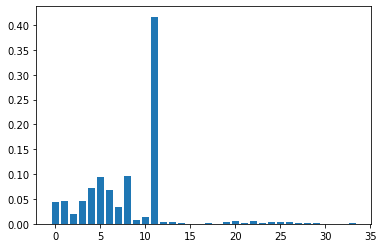

In [64]:
chi2_features = SelectKBest(chi2, k=20)        #using chi squared statistics
X = chi2_features.fit_transform(X_td, y_td)
y = y_td

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# print of plot:

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [65]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]   # random decision forests

max_features = ['auto', 'sqrt','log2']       # Varying features used

max_depth = [int(x) for x in np.linspace(10, 1000,10)]        # The max. # of levels in tree

min_samples_split = [2, 5, 10,14]                          # The min. # of samples for split

min_samples_leaf = [1, 2, 4,6,8]         # The min. of samples at inidividual leaf

criterion = ['entropy','gini'] # used for tree 


# Creation for random grid:

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':criterion}
              
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [71]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(weights='uniform', n_neighbors= 1, leaf_size=445, algorithm='brute')
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=445, n_neighbors=1)

In [73]:
y_pred = knn.predict(X_test)
model_report(y_test, y_pred)

Accuracy =  0.943127962085308
Precision =  0.9854014598540146
Recall =  0.9310344827586207
F1 Score =  0.9574468085106382
AUC Score = 0.9503657262277951
Kappa score =  0.8719401173376492
Error rate =  0.056872037914691975 



In [74]:
from sklearn.model_selection import RandomizedSearchCV

C = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]

random_grid = {'C':C,
               'kernel':kernel,
               'degree':degree}
print(random_grid)

{'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 50)

In [76]:
from sklearn.svm import SVC
svc = SVC()
svc_randomcv=RandomizedSearchCV(estimator= svc,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)

svc_randomcv.fit(X_train,y_train)       # random fit for model

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ......................C=13, degree=3, kernel=linear; total time=   0.0s
[CV] END ......................C=13, degree=3, kernel=linear; total time=   0.0s
[CV] END ......................C=13, degree=3, kernel=linear; total time=   0.0s
[CV] END ........................C=15, degree=10, kernel=rbf; total time=   0.0s
[CV] END ........................C=15, degree=10, kernel=rbf; total time=   0.0s
[CV] END ........................C=15, degree=10, kernel=rbf; total time=   0.0s
[CV] END .........................C=9, degree=4, kernel=poly; total time=   0.0s
[CV] END .........................C=9, degree=4, kernel=poly; total time=   0.0s
[CV] END .........................C=9, degree=4, kernel=poly; total time=   0.0s
[CV] END ........................C=15, degree=2, kernel=poly; total time=   0.0s
[CV] END ........................C=15, degree=2, kernel=poly; total time=   0.0s
[CV] END ........................C=15, degree=

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                              20],
                                        'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=100, verbose=2)

In [77]:
print('\n All results:')
print(svc_randomcv.cv_results_)


 All results:
{'mean_fit_time': array([0.00467229, 0.00712697, 0.00629886, 0.0037864 , 0.0023098 ,
       0.00552813, 0.00232307, 0.00404549, 0.00521104, 0.00318472,
       0.00380158, 0.00237425, 0.00420968, 0.00614667, 0.00397984,
       0.00401958, 0.00323232, 0.00426284, 0.00198825, 0.00640066,
       0.00381732, 0.00367483, 0.0041403 , 0.00228373, 0.00235597,
       0.00442187, 0.00524163, 0.00437713, 0.00232887, 0.00679739,
       0.00396919, 0.00397809, 0.00450651, 0.00250944, 0.00228182,
       0.00442584, 0.00748213, 0.00421786, 0.0034217 , 0.00401497,
       0.00232983, 0.0036447 , 0.00595919, 0.00343434, 0.00416621,
       0.00254448, 0.00230861, 0.0040973 , 0.0040195 , 0.00406599,
       0.004071  , 0.00529059, 0.00327317, 0.00334589, 0.00333627,
       0.00371655, 0.00428152, 0.00386469, 0.00210134, 0.00367212,
       0.00221999, 0.00296211, 0.00496674, 0.00384053, 0.00386341,
       0.00345095, 0.00379928, 0.00205127, 0.00322874, 0.00379427,
       0.00408387, 0.00229375

In [78]:
print('\n Best estimator:')
print(svc_randomcv.best_estimator_)


 Best estimator:
SVC(C=13, kernel='linear')


In [79]:
print('\n Best hyperparameters:')
print(svc_randomcv.best_params_)


 Best hyperparameters:
{'kernel': 'linear', 'degree': 3, 'C': 13}


In [85]:
svc = SVC(kernel='poly',degree=2,C=1)
svc.fit(X_train,y_train)

SVC(C=13, degree=1, kernel='poly')

In [81]:
y_pred = svc.predict(X_test)
model_report(y_test, y_pred)

Accuracy =  1.0
Precision =  1.0
Recall =  1.0
F1 Score =  1.0
AUC Score = 1.0
Kappa score =  1.0
Error rate =  0.0 



In [82]:
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]      # random decision forests

max_features = ["auto", "sqrt", "log2"]    # Varying features used

max_depth = [int(x) for x in np.linspace(10, 1000, 10)]   # The max. # of levels in tree

min_samples_split = [2, 5, 10, 14]   # The min. # of samples for split

min_samples_leaf = [1, 2, 4, 6, 8]   # The min. of samples at inidividual leaf

criterion = ["entropy", "gini"]  # used for tree 

# Creation for random grid:

random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "criterion": criterion,
}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 50)

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_randomcv = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=100,
    n_jobs=-1,
)

rf_randomcv.fit(X_train, y_train)  # random fit for model

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=120, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1400; total time=   1.7s
[CV] END criterion=gini, max_depth=120, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1400; total time=   1.6s
[CV] END criterion=gini, max_depth=120, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1400; total time=   1.5s
[CV] END criterion=gini, max_depth=340, max_features=sqrt, min_samples_leaf=1, min_samples_split=14,

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbose=2)

In [86]:
# output takes some to get

print('\n All results:')
print(rf_randomcv.cv_results_)


 All results:
{'mean_fit_time': array([0.22783383, 1.49044204, 2.1106801 , 2.11123681, 0.21840135,
       0.63065473, 2.19258261, 1.5211885 , 1.4514571 , 0.63838291,
       0.6239353 , 1.47473447, 0.42421929, 0.64187113, 0.43831317,
       0.21695749, 1.94063409, 0.63589311, 0.85466123, 2.1301256 ,
       0.21756728, 1.08341281, 1.7038238 , 0.21489596, 1.25049551,
       0.85553424, 0.85468896, 0.43615556, 0.86339498, 0.21765542,
       0.85661697, 0.85290146, 0.43513282, 1.24289815, 2.11531266,
       1.71394038, 1.69160326, 1.70335722, 2.11779579, 1.89693014,
       0.63215001, 2.15150396, 0.84957735, 1.54062168, 2.16626891,
       0.85663247, 0.83839329, 1.47748295, 1.91558305, 0.64254642,
       1.69172343, 2.11128155, 1.51477567, 0.62582954, 1.45285384,
       0.2148486 , 1.50354664, 1.06957515, 0.83805728, 1.90167061,
       2.11987789, 0.43657565, 0.21303789, 2.1292491 , 0.42360934,
       0.61899694, 1.87658803, 2.07828434, 0.82165257, 2.10034815,
       1.26699591, 0.64380232

In [87]:
print('\n Best estimator:')
print(rf_randomcv.best_estimator_)


 Best estimator:
RandomForestClassifier(criterion='entropy', max_depth=1000, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=200)


In [88]:
print('\n Best hyperparameters:')
print(rf_randomcv.best_params_)


 Best hyperparameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 1000, 'criterion': 'entropy'}
